# Baseline for Higgs Boson Detection

## Import packages

In [1]:
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.pipeline import PipelineModel, Pipeline
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.evaluation import (
    MulticlassClassificationEvaluator,
    BinaryClassificationEvaluator,
)
from pyspark.sql.functions import col, expr, broadcast
from pyspark.ml.functions import vector_to_array
from pyspark.sql import SparkSession
from pyspark import SparkContext
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os

## Create SparkContext and SparkSession

In [2]:
sc = SparkContext.getOrCreate()
spark = SparkSession(sc)

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/05/13 18:52:51 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
24/05/13 18:52:52 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


In [3]:
RAW_DATA_FOLDER = "raw_data"
MODELS_FOLDER = "models"
TRAIN = False
SCHEMA = [
    "signal",
    "lepton pT",
    "lepton eta",
    "lepton phi",
    "missing energy magnitude",
    "missing energy phi",
    "jet 1 pt",
    "jet 1 eta",
    "jet 1 phi",
    "jet 1 b-tag",
    "jet 2 pt",
    "jet 2 eta",
    "jet 2 phi",
    "jet 2 b-tag",
    "jet 3 pt",
    "jet 3 eta",
    "jet 3 phi",
    "jet 3 b-tag",
    "jet 4 pt",
    "jet 4 eta",
    "jet 4 phi",
    "jet 4 b-tag",
    "m_jj",
    "m_jjj",
    "m_lv",
    "m_jlv",
    "m_bb",
    "m_wbb",
    "m_wwbb",
]

## Read Train CSV, transform and load to Dataframe

In [4]:
rdd = sc.textFile(os.path.join(RAW_DATA_FOLDER, "HIGGS.csv"))
rdd = rdd.map(
    lambda row: [
        int(float(v)) if i == 0 else float(v) for i, v in enumerate(row.split(","))
    ]
)
df = rdd.toDF(schema=SCHEMA)
train_df, test_df = df.randomSplit([0.7, 0.3], seed=42)

## Build Baseline Model

if TRAIN is True, this will train a Baseline Model using train csv

if TRAIN is False, this will load a trained Baseline Model from `models`

In [5]:
model = None
if TRAIN:
    vector_assembler = VectorAssembler(
        inputCols=[c for c in SCHEMA if c != "signal"], outputCol="features"
    )
    classifier = LogisticRegression(featuresCol="features", labelCol="signal")
    pipeline = Pipeline(stages=[vector_assembler, classifier])
    model = pipeline.fit(train_df)
    model.save(os.path.join(MODELS_FOLDER, "baseline"))
else:
    model = PipelineModel.load(os.path.join(MODELS_FOLDER, "baseline"))

24/05/13 18:53:09 WARN GarbageCollectionMetrics: To enable non-built-in garbage collector(s) List(G1 Concurrent GC), users should configure it(them) to spark.eventLog.gcMetrics.youngGenerationGarbageCollectors or spark.eventLog.gcMetrics.oldGenerationGarbageCollectors
24/05/13 18:53:22 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
24/05/13 18:53:22 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.VectorBLAS
24/05/13 18:53:31 WARN MemoryStore: Not enough space to cache rdd_21_80 in memory! (computed 1024.6 KiB so far)
24/05/13 18:53:31 WARN BlockManager: Persisting block rdd_21_80 to disk instead.
24/05/13 18:53:41 WARN MemoryStore: Not enough space to cache rdd_21_169 in memory! (computed 1024.6 KiB so far)
24/05/13 18:53:41 WARN BlockManager: Persisting block rdd_21_169 to disk instead.
24/05/13 18:53:49 WARN MemoryStore: Not enough space to cache rdd_21_3 in memory! (computed 7.1 MiB so far)
24/05/13 18:53:49 

## Build Binary Classification Evaluators and Visualizers

In [6]:
evaluators = {
    "accuracy": MulticlassClassificationEvaluator(
        labelCol="signal", predictionCol="prediction", metricName="accuracy"
    ),
    "precision": MulticlassClassificationEvaluator(
        labelCol="signal", predictionCol="prediction", metricName="weightedPrecision"
    ),
    "recall": MulticlassClassificationEvaluator(
        labelCol="signal", predictionCol="prediction", metricName="weightedRecall"
    ),
    "f1": MulticlassClassificationEvaluator(
        labelCol="signal", predictionCol="prediction", metricName="f1"
    ),
    "areaUnderROC": BinaryClassificationEvaluator(
        labelCol="signal", rawPredictionCol="rawPrediction", metricName="areaUnderROC"
    ),
    "areaUnderPR": BinaryClassificationEvaluator(
        labelCol="signal", rawPredictionCol="rawPrediction", metricName="areaUnderPR"
    ),
}
metrics = []

In [7]:
def evaluate(predictions, split):
    accuracy = evaluators["accuracy"].evaluate(predictions)
    precision = evaluators["precision"].evaluate(predictions)
    recall = evaluators["recall"].evaluate(predictions)
    f1 = evaluators["f1"].evaluate(predictions)
    auc_roc = evaluators["areaUnderROC"].evaluate(predictions)
    auc_pr = evaluators["areaUnderPR"].evaluate(predictions)
    return {
        "Split": split,
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1": f1,
        "AreaUnderROC": auc_roc,
        "AreaUnderPR": auc_pr,
    }

In [8]:
def plot_confusion_matrix(predictions, split, ax):
    TP = predictions.filter(
        (predictions.prediction == 1) & (predictions.signal == 1)
    ).count()
    TN = predictions.filter(
        (predictions.prediction == 0) & (predictions.signal == 0)
    ).count()
    FP = predictions.filter(
        (predictions.prediction == 1) & (predictions.signal == 0)
    ).count()
    FN = predictions.filter(
        (predictions.prediction == 0) & (predictions.signal == 1)
    ).count()
    confusion_matrix = [[TP, FP], [FN, TN]]
    _ = sns.heatmap(
        confusion_matrix,
        annot=True,
        fmt="d",
        cmap="Blues",
        square=True,
        cbar=False,
        ax=ax,
    )
    ax.set_title(f"Confusion Matrix for {split}")
    ax.set_ylabel("True Label")
    ax.set_xlabel("Predicted Label")

In [9]:
def plot_precision_recall_curve(predictions, split, ax):
    slim_preds = predictions.select(["signal", "probability", "prediction"]).withColumn(
        "probability_array", vector_to_array("probability")
    )
    # Create a DataFrame of threshold values
    thresholds = np.linspace(0, 1, num=100)
    threshold_df = spark.createDataFrame(
        [(float(t),) for t in thresholds], ["threshold"]
    )
    cross_joined = slim_preds.crossJoin(broadcast(threshold_df))
    # Define the conditions for TP, FP, TN, FN
    metrics_df = (
        cross_joined.withColumn(
            "Metric",
            expr(
                "CASE "
                + " WHEN probability_array[1] >= threshold AND signal = 1 THEN 'TP' "
                + " WHEN probability_array[1] >= threshold AND signal = 0 THEN 'FP' "
                + " WHEN probability_array[1] < threshold AND signal = 1 THEN 'FN' "
                + " ELSE 'TN' END"
            ),
        )
        .groupBy("threshold")
        .pivot("Metric")
        .count()
    )
    # Calculate precision and recall
    result_df = metrics_df.withColumn(
        "Precision", col("TP") / (col("TP") + col("FP"))
    ).withColumn("Recall", col("TP") / (col("TP") + col("FN")))
    # Collect results for plotting if necessary
    result_data = (
        result_df.select("threshold", "Precision", "Recall")
        .orderBy("threshold")
        .collect()
    )
    # Plotting
    precisions = [
        row["Precision"] for row in result_data if row["Precision"] is not None
    ]
    recalls = [row["Recall"] for row in result_data if row["Recall"] is not None]
    # Filter out None values and ensure that both precision and recall are present
    filtered_data = [
        (row["Precision"], row["Recall"])
        for row in result_data
        if row["Precision"] is not None and row["Recall"] is not None
    ]
    # x[1] is the recall
    sorted_data = sorted(filtered_data, key=lambda x: x[1])
    # Unpack the sorted data
    precisions, recalls = zip(*sorted_data)
    average_precision = 0.0
    for i in range(1, len(precisions)):
        average_precision += (recalls[i] - recalls[i - 1]) * precisions[i]
    # Plotting
    ax.plot(recalls, precisions, color="tab:blue", alpha=0.7)
    ax.fill_between(recalls, precisions, color="tab:blue", alpha=0.2)
    ax.set_title(f"Precision-Recall Curve for {split} (AP={average_precision:.4f})")
    ax.set_ylabel("Precision")
    ax.set_xlabel("Recall")
    ax.set_ylim([0.0, 1.0])
    ax.set_xlim([0.0, 1.0])

In [10]:
def plot_roc_curve(predictions, split, ax):
    slim_preds = predictions.select(["signal", "probability", "prediction"]).withColumn(
        "probability_array", vector_to_array("probability")
    )
    # Create a DataFrame of threshold values
    thresholds = np.linspace(0, 1, num=100)
    threshold_df = spark.createDataFrame(
        [(float(t),) for t in thresholds], ["threshold"]
    )
    cross_joined = slim_preds.crossJoin(broadcast(threshold_df))
    # Define the conditions for TP, FP, TN, FN
    metrics_df = (
        cross_joined.withColumn(
            "Metric",
            expr(
                "CASE "
                + " WHEN probability_array[1] >= threshold AND signal = 1 THEN 'TP' "
                + " WHEN probability_array[1] >= threshold AND signal = 0 THEN 'FP' "
                + " WHEN probability_array[1] < threshold AND signal = 1 THEN 'FN' "
                + " ELSE 'TN' END"
            ),
        )
        .groupBy("threshold")
        .pivot("Metric")
        .count()
    )
    metrics_summed = metrics_df.groupBy("threshold").sum("TP", "FP", "TN", "FN")
    # Calculate TPR and FPR
    result_df = metrics_summed.withColumn(
        "FPR", col("sum(FP)") / (col("sum(FP)") + col("sum(TN)"))
    ).withColumn("TPR", col("sum(TP)") / (col("sum(TP)") + col("sum(FN)")))
    # Collect results to the driver
    result_data = (
        result_df.select("threshold", "FPR", "TPR").orderBy("threshold").collect()
    )
    # Filter out None values from the results
    filtered_data = [
        row for row in result_data if row["FPR"] is not None and row["TPR"] is not None
    ]
    # Sort by FPR
    sorted_data = sorted(filtered_data, key=lambda x: x["FPR"])
    fprs = [row["FPR"] for row in sorted_data]
    tprs = [row["TPR"] for row in sorted_data]
    # Calculate AUC using the trapezoidal rule
    roc_auc = np.trapz(tprs, fprs)
    # Plotting
    ax.plot(
        fprs, tprs, color="tab:orange", lw=2, label=f"ROC Curve (Area={roc_auc:.4f})"
    )
    ax.plot([0, 1], [0, 1], color="tab:blue", lw=2, linestyle="--")
    ax.set_xlabel("False Positive Rate")
    ax.set_ylabel("True Positive Rate")
    ax.set_title(f"Receiver Operating Characteristic for {split}")
    ax.legend(loc="lower right")
    ax.set_ylim([0.0, 1.0])
    ax.set_xlim([0.0, 1.0])

## Predictions and Metrics for Train split

In [11]:
train_predictions = model.transform(train_df)

In [12]:
metrics.append(evaluate(predictions=train_predictions, split="Train"))

In [13]:
# fig, ax = plt.subplots(1, 1, figsize=(8, 6))
# plot_confusion_matrix(train_predictions, "Train", ax)

In [14]:
# fig, ax = plt.subplots(1, 1, figsize=(6, 6))
# plot_roc_curve(train_predictions, "Train", ax)

In [15]:
# fig, ax = plt.subplots(1, 1, figsize=(6, 6))
# plot_precision_recall_curve(train_predictions, "Train", ax)

## Predictions and Metrics for Test split

In [16]:
test_predictions = model.transform(test_df)

In [17]:
metrics.append(evaluate(predictions=test_predictions, split="Test"))

24/05/13 19:00:18 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


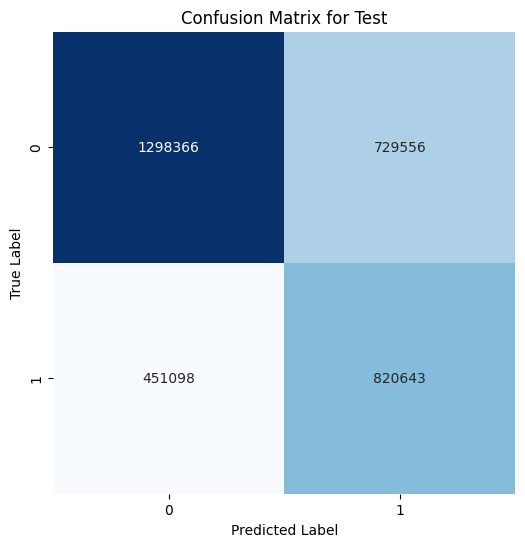

In [18]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
plot_confusion_matrix(test_predictions, "Test", ax)

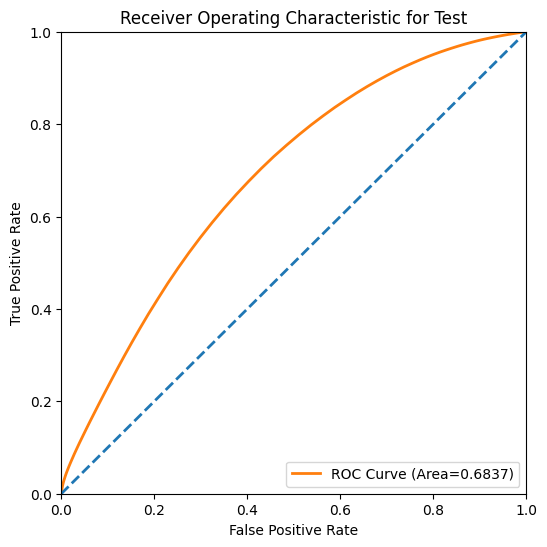

In [19]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
plot_roc_curve(test_predictions, "Test", ax)

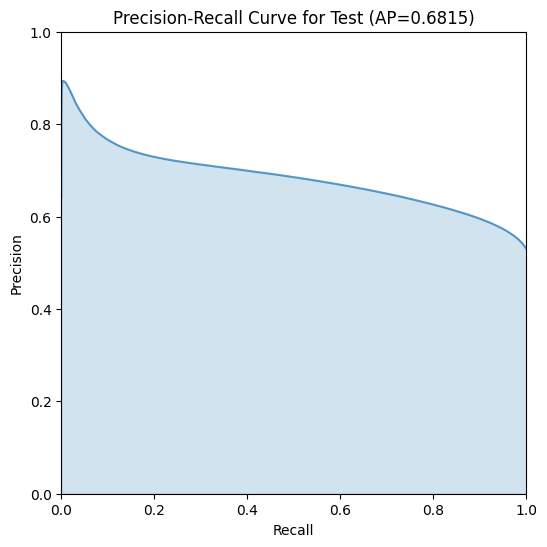

In [20]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
plot_precision_recall_curve(test_predictions, "Test", ax)

## Print Metrics

In [21]:
spark.createDataFrame(metrics).show(truncate=False)

+------------------+------------------+------------------+------------------+------------------+------------------+-----+
|Accuracy          |AreaUnderPR       |AreaUnderROC      |F1                |Precision         |Recall            |Split|
+------------------+------------------+------------------+------------------+------------------+------------------+-----+
|0.6415177673392736|0.6836518869673811|0.684395326513634 |0.6369952170824575|0.6420154345092818|0.6415177673392736|Train|
|0.6421895205661912|0.6841948494259477|0.6848307684402213|0.6377242295910832|0.6426153885354211|0.6421895205661912|Test |
+------------------+------------------+------------------+------------------+------------------+------------------+-----+

